# LocImpBranchPro: inference of R_t

The first part of the notebook includes a forward simulation of the local incidence numbers for an example branching process model with both local and imported cases. The reproduction number profile is assumed to be a step function with only one jump. The incidence results are displayed as a barplot.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- explicit calculation;
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd
import stan
import arviz as az
import nest_asyncio
nest_asyncio.apply()

num_timepoints = 30 # number of days for incidence data

# Build the imported cases
ic_mean = 70
imported_times = np.arange(1,(num_timepoints+1))
imported_cases = scipy.stats.poisson.rvs(ic_mean, size=num_timepoints)

## Parameterize example branching process model with local and imported cases

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

In [3]:
# Construct LocImpBranchProModel object
epsilon = 1

initial_r = 3
serial_interval = disc_w
m = branchpro.LocImpBranchProModel(initial_r, serial_interval, epsilon)

new_rs = [1.5, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

m.set_imported_cases(imported_times, imported_cases)
locally_infected_cases = m.simulate(parameters, times)

print(locally_infected_cases)

[100.   0.  33.  60.  94. 160. 162. 265. 278. 372. 463. 526. 615. 712.
 839. 952. 366. 431. 367. 343. 268. 231. 210. 187. 161. 164. 134. 153.
 111. 102.]


## Plot local incidence numbers and imported cases

In [4]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=imported_cases,
        name='Imported Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Compute the posterior distribution using explicit method

In [5]:
# Posterior of R_t
#epsilon = 0.5

tau = 6
R_t_start = tau+1
a = 1
b = 1/5

shape = []
rate = []
mean = []

# print(len(serial_interval))
# print(len(locally_infected_cases))
# print(len(imported_cases))

i=0
for t in range(R_t_start,num_timepoints):
#     print(t)
    shape.append( a + math.fsum(locally_infected_cases[(t-tau):(t+1)]) )
    sum_var_loc = 0
    sum_var_imp = 0
    for k in range(t-tau,t+1):
        vec1 = locally_infected_cases[(k-1)::-1] # I_loc_(k-1), ... , I_loc_0
        vec2 = imported_cases[(k-1)::-1] # I_imp_(k-1), ... , I_imp_0
        vec3 = serial_interval[:k] # w_1, ... , w_k
        
#         print(len(vec1))
#         print(len(vec2))
#         print(len(vec2))
#         print(np.multiply(vec1,vec3))
#         print(np.multiply(vec2,vec3))
        sum_var_loc += math.fsum( np.multiply(vec1,vec3) )
        sum_var_imp += math.fsum( np.multiply(vec2,vec3) )
    rate.append( 1/b + sum_var_loc + epsilon * sum_var_imp)
    i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

mean = np.divide(shape, rate)

post_dist = scipy.stats.gamma(shape, scale = 1/np.array(rate))
post_dist_interval = post_dist.interval(.95)

# print(shape)
# print(rate)
# print(mean)

## Inference plot using explicit calculation results

In [6]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[1.5] + L2*[0.5]
})

interval = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': mean,
    'Lower bound CI': post_dist_interval[0],
    'Upper bound CI': post_dist_interval[1],
    'Central Probability': (L1+L2) * [0.95]
})

In [7]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using pre-computed posterior class method

In [8]:
# Same inference, but using the LocImpBranchProPosterior
epsilon = 1
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': imported_cases
    }
)

inference = branchpro.LocImpBranchProPosterior(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

## Inference plot using class method results

In [9]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using sampling class method

In [10]:
# Same inference, but using the LocImpPoissonBranchProPosterior
epsilon = 1
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': imported_cases
    }
)

inference_new = branchpro.PoissonBranchProLogPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    tau = tau,
    alpha=a,
    beta=1/b,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon)


/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_mcmc/_nuts.py:260: RuntimeWarning:

overflow encountered in exp

/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_mcmc/_nuts.py:159: RuntimeWarning:

overflow encountered in exp



Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     12     0.25     1       0.25     1       0.25     1        0:00.0
1     15     0.25     1       0.25     1       0.25     1        0:00.0
2     18     0.25     1       0.25     1       0.25     1        0:00.0
3     21     0.25     1       0.25     1       0.25     1        0:00.0
20    294    0.745    5       0.756    5       0.727    6        0:00.2
40    930    0.773    8       0.76     8       0.769    11       0:00.6
60    1326   0.752    6       0.745022 7       0.752    7        0:00.9
80    1806   0.752    8       0.767    7       0.781    8        0:01.2
100   2045   0.678    8       0.683    5       0.742    7        0:01.3
Halting: Maximum number of iterations (100) reached.
Done!
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  --

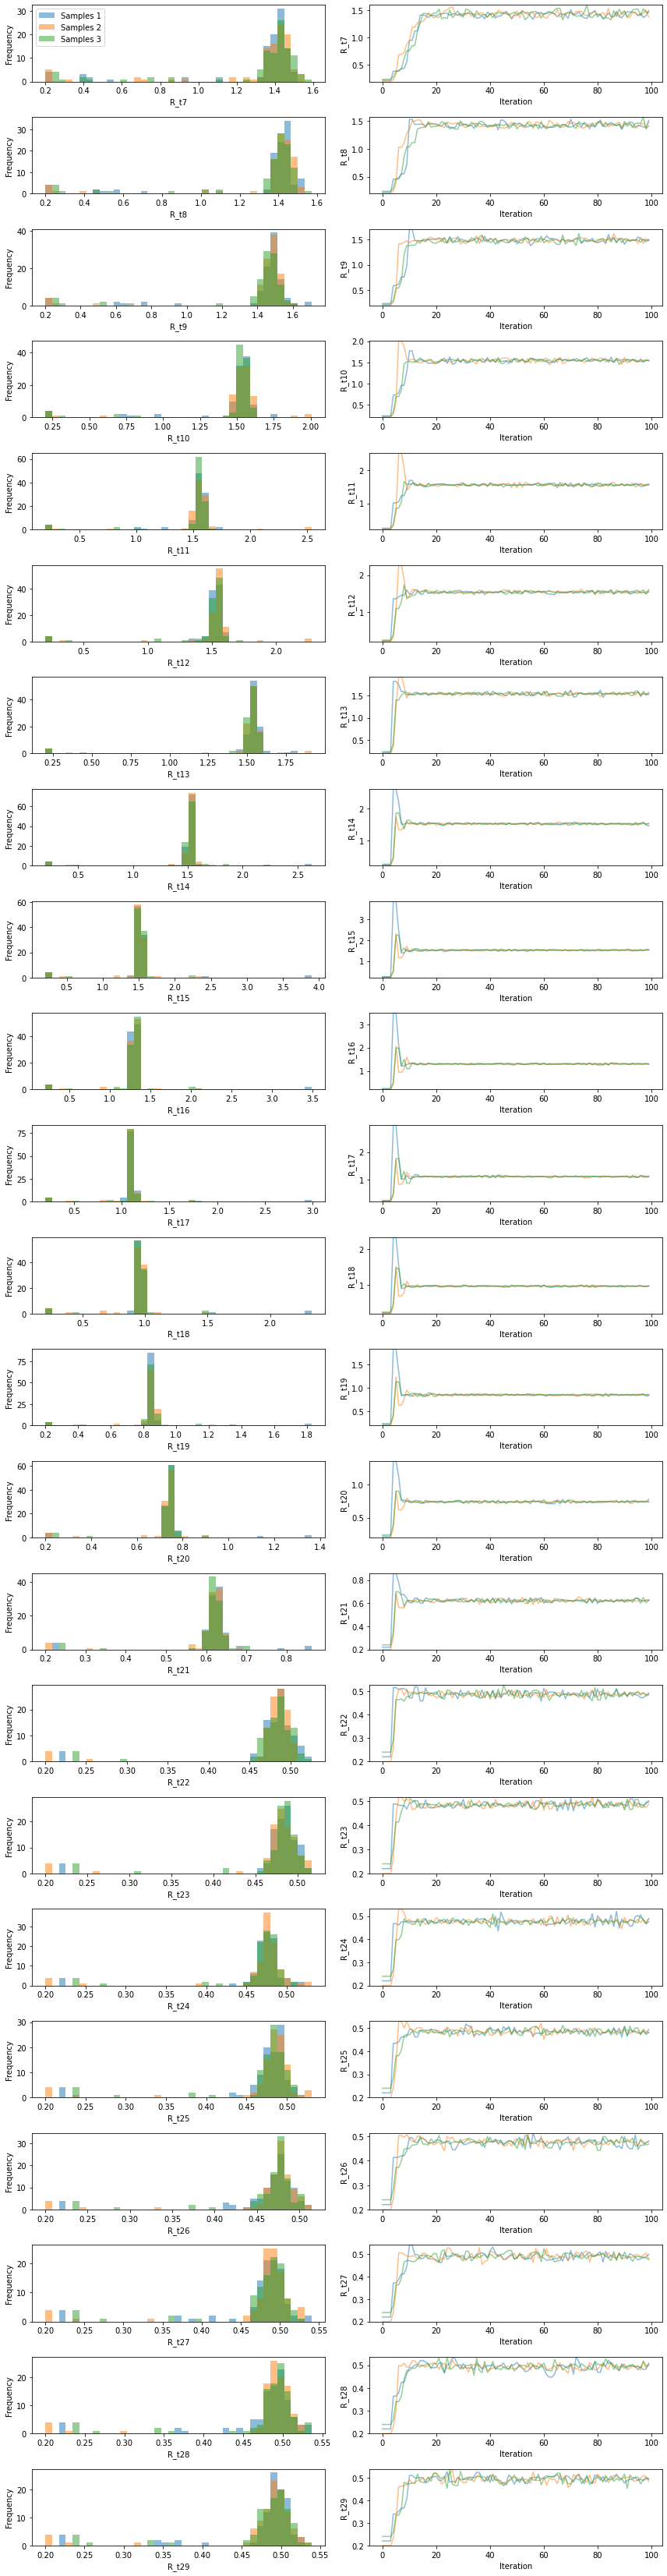

In [11]:
samples = inference_new.run_inference(num_iter=100)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(inference_new.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + R_t_start))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 50:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [12]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [13]:
dLl = []
old_r_profile = ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
    new_r_profile = old_r_profile.copy()
    new_r_profile[_] = old_r_profile[_] + 10**(-5)
    dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[-24.90565675543621, -32.111071777762845, -5.097015673527494, 41.415364103158936, 62.39352151169441, 51.25239185872487, 57.931341143557795, 41.466113179922104, 42.85208706278354, 5502.601230182336, 4878.7114828883205, 4117.034542650799, 3312.0660722488533, 2328.476618276909, 1165.632224365254, -115.78274861676617, -122.75700100872199, -164.3888961552875, -97.19510617287595, -126.75562466029076, -42.6286587753566, -19.931095994252246, -23.06137075720471]
[-24.903936713167013, -32.108734052016075, -5.093923890592009, 41.41935105475159, 62.39846891382331, 51.25834985275833, 57.93852188758183, 41.474568941672715, 42.86204040110397, 5502.690689274634, 4878.800301709816, 4117.120181505627, 3312.1462711152317, 2328.5479372013733, 1165.6913835180676, -115.73842943996715, -122.71626142500918, -164.35355667849217, -97.16382646236525, -126.72852490980495, -42.60385904939267, -19.908696507216064, -23.0411310010345]


In [14]:
theta_hat = inference_new.run_optimisation()[0]
S_vector = np.multiply(np.reciprocal(np.array(shape)-1), np.square(theta_hat))
S = np.diag(S_vector)

q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta.mean,
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13     -18621.37 -18621.37   0:00.1
1     26     -14371.78 -14371.78   0:00.1
2     39     -13075.65 -13075.65   0:00.1
3     52     -13075.65 -14254.81   0:00.1
20    273    -6671.705 -7654.473   0:00.2
40    533    -4028.135 -4028.135   0:00.3
60    793    -3642.379 -3642.379   0:00.5
80    1053   -3597.474 -3598.167   0:00.6
100   1313   -3584.945 -3584.945   0:00.7
120   1573   -3584.084 -3584.089   0:00.9
140   1833   -3583.832 -3583.832   0:01.0
160   2093   -3583.803 -3583.805   0:01.2
180   2353   -3583.791 -3583.791   0:01.3
200   2613   -3583.789 -3583.789   0:01.4
220   2873   -3583.789 -3583.789   0:01.5
228   2964   -3583.789 -3583.789   0:01.6
Halting: No significant change for 100 iterations.
[1.41961877 1.42591736 1.48484301 1.547939   1.56099289 1.54044311
 1.53826747 1.52232692 1.51960861 1.297

In [15]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using STAN

In [16]:
locimp_poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    array [N] int impI; // imported incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real epsilon; // epsilon
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (
                (effective_no_infectives(N, S, k, I, revSI) != 0) ||
                (effective_no_infectives(N, S, k, impI, revSI) != 0)) {
                    I[k] ~ poisson (
                        R[t-tau] * (effective_no_infectives(
                            N, S, k, I, revSI) + epsilon *
                            effective_no_infectives(
                                N, S, k, impI, revSI))); // likelihood
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (1, 5); // prior of R
    }
}
"""

locimp_poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': locally_infected_cases.astype(np.integer).tolist(),
    'impI': imported_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'epsilon': epsilon}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_76846/1595533630.py:57: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_76846/1595533630.py:58: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [17]:
locimp_posterior = stan.build(
    locimp_poisson_model, data=locimp_poisson_data, random_seed=10)

locimp_fit = locimp_posterior.sample(num_chains=3, num_samples=1000)

locimp_samples = az.from_pystan(
    locimp_fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(locimp_samples)

Building...

In file included from /Users/ioaros/Library/Caches/httpstan/4.10.1/models/dyevj5s2/model_dyevj5s2.cpp:2:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
In file included from /Users/ioaros/Library/Caches/httpstan/4.10.1/mode

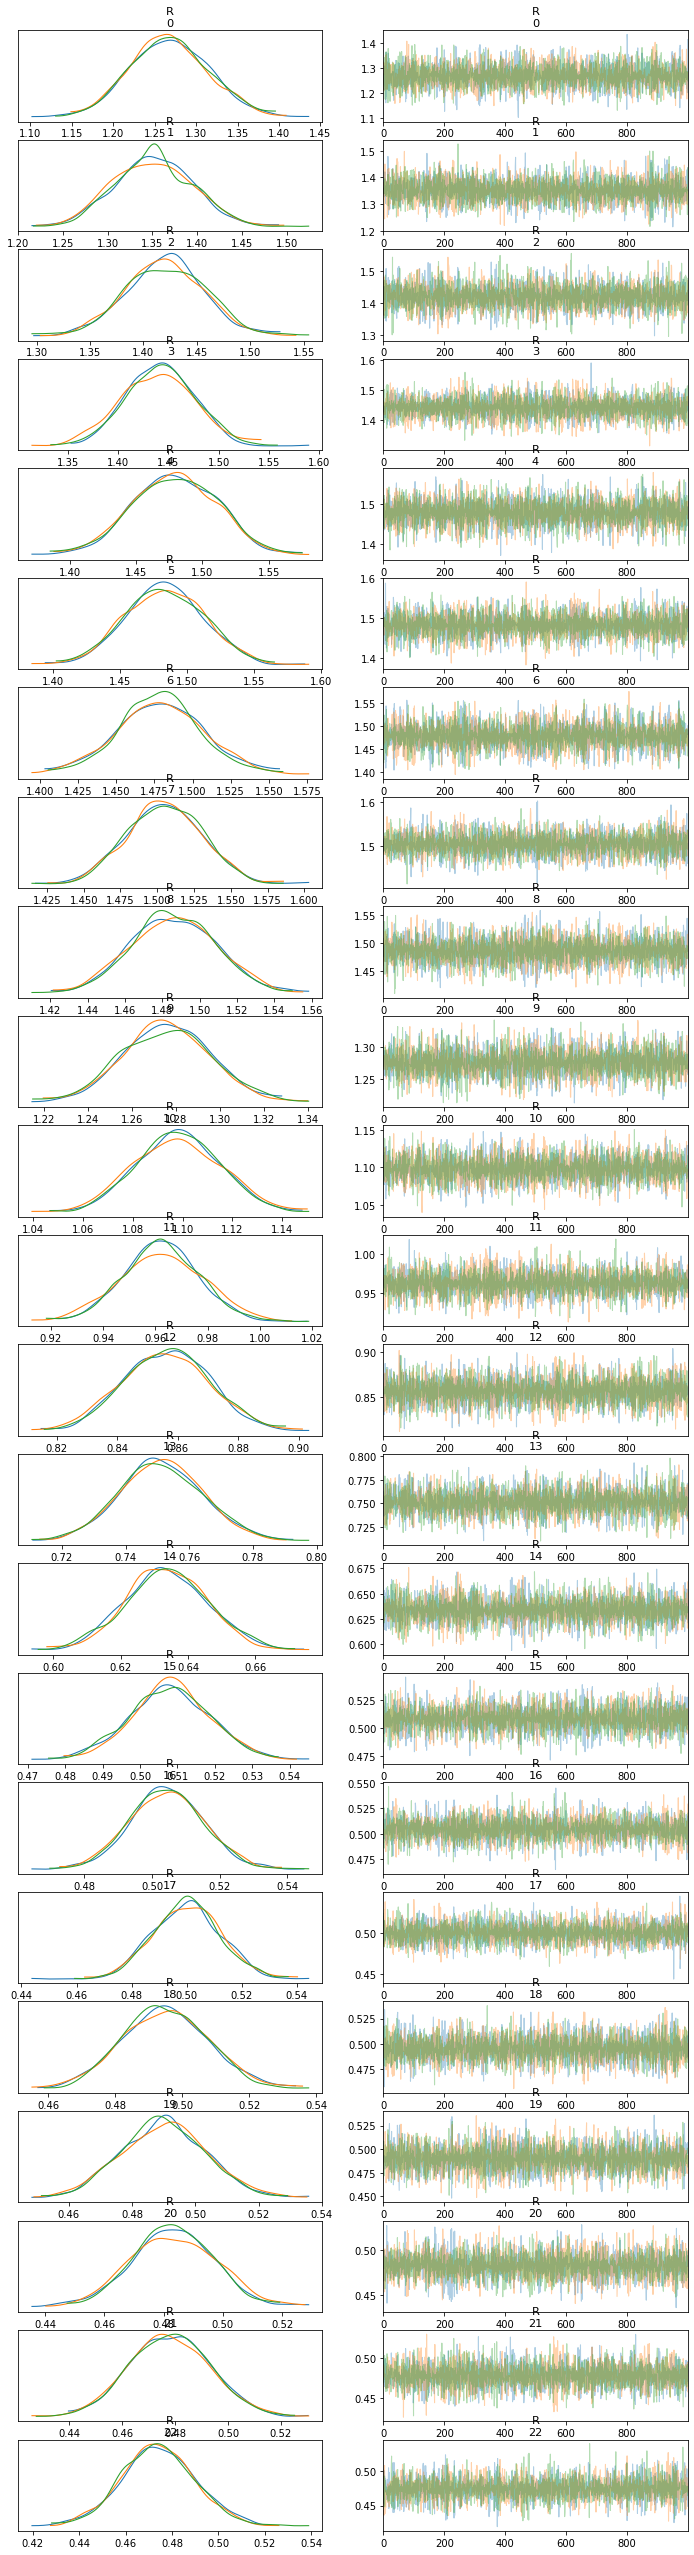

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

In [ ]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    locimp_samples,
    var_names=('R'),
    filter_vars='like',
    compact=False,
    show=True)

In [ ]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = locimp_fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

In [ ]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

